# Text Classification in Polish with ULMFiT and fastai

This is a demo on how to use fastai library with sentencecode to train a Polish language model, and use it then to develop a classification model. For demo purposes, I need a small sample corpus for the language model, and a small sample classification dataset. I will use them to develop a pipeline that should be quick to train, so that I know that it works and can use it later for more challenging datasets.




# Set up the notebook

In [ ]:
#start by mounting google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
base_dir = "/content/gdrive/My Drive/ULMFIT_PL_DEMO/"
#sentencecode breaks when I use the google drive directory because of the space in "My Drive" (let me know if you know how to fix it!) - so I copy files to server root and work from there
train_dir = "/root/fastai/texts/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Install and import fastai library
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.text import *

Updating fastai...
Done.


In [ ]:
# I'll be copying over key files to a separate directory directly on the colab VM - otherwise the space in filepath 'My Drive' causes issues with sentencepiece
mkdir -p /root/fastai/texts

In [ ]:
# create working directory in google drive
mkdir -p /content/gdrive/My\ Drive/ULMFIT_PL_DEMO

# Prepare the data

In [ ]:
#get dataset files from my google drive
import gdown

url1 = 'https://drive.google.com/uc?id=1TxHZphZxSQZUTzBiHvSSSlCbxasHFWAN'
output1 = base_dir + 'quo_vadis_raw.txt'
url2 = 'https://drive.google.com/uc?id=1udS7gl3PiqGTgNU8mLDuOVTB05HSKfIz'
output2 = base_dir + 'janko_muzykant_clas.csv'


gdown.download(url1, output1, quiet=False)
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1TxHZphZxSQZUTzBiHvSSSlCbxasHFWAN
To: /content/gdrive/My Drive/ULMFIT_PL_DEMO/quo_vadis_raw.txt
100%|██████████| 1.19M/1.19M [00:00<00:00, 69.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1udS7gl3PiqGTgNU8mLDuOVTB05HSKfIz
To: /content/gdrive/My Drive/ULMFIT_PL_DEMO/janko_muzykant_clas.csv
100%|██████████| 17.1k/17.1k [00:00<00:00, 4.65MB/s]


'/content/gdrive/My Drive/ULMFIT_PL_DEMO/janko_muzykant_clas.csv'

In [ ]:
#pre-processing languange model file (I'm sure this can be done more efficiently...)

import csv
import re
import pandas as pd

source_file = base_dir + 'quo_vadis_raw.txt'
tmp_file = base_dir + 'QV_tmp.csv'
target_file = base_dir + 'lm_corpus.csv'

#pre-processing a csv corpus file, need to refactor later, but works for now

string = ''

with open(source_file) as file:
  for line in file:
    for l in re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s",line):
      string += l
      string += '\n'

f = open(tmp_file,'w')
f.write(string)
f.close()
    
df = pd.read_csv(tmp_file, delimiter="\n", header = None, names = ['text'])
df.to_csv(target_file, index=False)
df.head()

,text
0,Henryk Sienkiewicz
1,Quo vadis
2,Rozdział pierwszy
3,Petroniusz obudził się zaledwie koło południa ...
4,"Poprzedniego dnia był na uczcie u Nerona, któr..."


In [ ]:
# now let's add sentences from the smaller data set to language model corpus
df2 = pd.read_csv(base_dir + 'janko_muzykant_clas.csv')
df2 = df2.drop(['label', 'is_valid'], axis=1)
df = pd.concat([df, df2], ignore_index=True)
df.tail()

,text
10738,I co to za lud artystów.
10739,On est heureux de chercher lá-bas des
10740,talents et de les protéger...
10741,dodała panna.
10742,Nad Jankiem szumiały brzozy...


In [ ]:
#save the language model corpus file
target_corpus = base_dir + 'joint_lm_corpus.csv'
df.to_csv(target_corpus, index=False)

In [ ]:
#copy over to the server root to avoid breaking sentencepiece
!bash -c 'cp /content/gdrive/My\ Drive/ULMFIT_PL_DEMO/joint_lm_corpus.csv /root/fastai/texts/joint_lm_corpus.csv'
!bash -c 'cp /content/gdrive/My\ Drive/ULMFIT_PL_DEMO/janko_muzykant_clas.csv /root/fastai/texts/clas_corpus.csv'


In [ ]:
#quality check
df = pd.read_csv('/root/fastai/texts/joint_lm_corpus.csv')
df.head()

,text
0,Henryk Sienkiewicz
1,Quo vadis
2,Rozdział pierwszy
3,Petroniusz obudził się zaledwie koło południa ...
4,"Poprzedniego dnia był na uczcie u Nerona, któr..."


# Training the Language Model

In [ ]:
#we need to install sentencepiece
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 1.4MB/s 


In [ ]:
path = Path("/root/fastai/texts/")

bs = 48
processor = SPProcessor(lang='pl')
# processor = SPProcessor()

data_lm = (TextList.from_csv(path, 'joint_lm_corpus.csv', processor=processor)
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs)
          )
data_lm.save('data_lm.pkl')

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


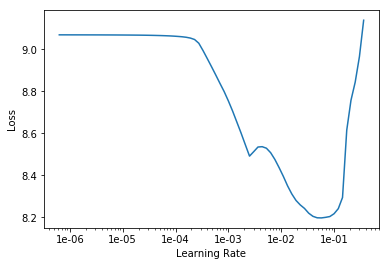

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
# Not sure - if I have learner with pretrained=False, do I need to unfreeze explicitly?
# Hope to find out in Fast.ai Part 2! Right now I'm mostly copy-pasting code from the Part 1 IMDB notebook...

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.865044,6.555590,0.061343,00:15


In [ ]:
learn.save(base_dir + 'fit_head')

In [ ]:
learn.load(base_dir + 'fit_head');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.451967,6.220999,0.131845,00:15
1,6.087717,5.872290,0.150694,00:16
2,5.762241,5.489414,0.161541,00:16
3,5.491202,5.326522,0.169213,00:17
4,5.332908,5.571834,0.151455,00:16
5,5.169986,5.177565,0.179431,00:16
6,5.028393,5.145644,0.181746,00:16
7,4.899536,5.064345,0.189021,00:16
8,4.759845,5.019300,0.191534,00:16
9,4.636858,5.001264,0.195172,00:16


In [ ]:
learn.save(base_dir + 'qv_lm_model')

In [ ]:
learn.load(base_dir + 'qv_lm_model');

In [ ]:
#quality check - does the model predict sensible tokens?
TEXT = "tak to było"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

tak to było ▁dobrze , ▁że ▁to ▁jest ▁odpowiedzi , ▁i ▁dziś ▁jeszcze ▁pozostanie ▁do ▁xxmaj ▁ligii , ▁a ▁przynajmniej ▁mnie ▁opuścić . ▁xxbos ▁xxmaj ▁po ▁chwili ▁jednak ▁cezar , ▁na ▁synu ▁xxmaj ▁winicjusza ▁i ▁augustianie , ▁xxmaj ▁winicjusz ▁zerwał ▁się , ▁rzekł
tak to było ! ▁xxmaj ▁wiem , ▁że ▁xxmaj ▁chrystus ▁wróci ▁kres ch ▁słuchali ▁na ▁miejscu , ▁dopóki ▁oni , ▁jeśli ▁nie ▁cofa ▁się ▁jej , ▁a ▁jednak ▁i ▁xxmaj ▁ligią , ▁ale ▁tak ▁mi ▁jej , ▁że ▁na ▁przykład ▁xxmaj ▁chrystusa ,


In [ ]:
learn.save_encoder(base_dir + 'fine_tuned_enc')

# Training the Classification Model

Now let's switch over to using the sentence encoder to train a classification model based on the smaller labelled dataset. 





In [ ]:
# Let's start by looking at our classification dataset
df = pd.read_csv(train_dir + 'clas_corpus.csv')
df.head()

,text,label,is_valid
0,JANKO MUZYKANT,narrator,False
1,"Przyszło to na świat wątłe, słabe.",narrator,False
2,"Kumy, co się były zebrały przy tapczanie położ...",narrator,False
3,"Kowalka Szymonowa, która była najmądrzejsza, p...",narrator,False
4,"Dajta powiada to zapalę nad wami gromnicę, już...",dialog,False


In [ ]:
bs = 16

data_clas = (TextList.from_df(df, processor=processor, vocab=data_lm.vocab)
             .split_from_df()
             .label_from_df(cols=1, classes=['narrator', 'dialog'])
             .databunch(bs=bs))

data_clas.save(base_dir + 'data_clas.pkl')


In [ ]:
data_clas.show_batch()

text,target
"▁xxbos ▁xxmaj ▁ludzie ▁tańc owali ▁ob er ta s a , ▁czasem ▁jaki ▁par ob ek ▁po k rzy ki wa ł : ▁"" u - h a !"" ▁xxmaj ▁słychać ▁było ▁tu panie ▁ bu tów , ▁to ▁znów ▁głosy ▁dziew czy n : ▁"" czegóż ? "" ▁xxmaj ▁skrzypki ▁śpiewał y ▁cicho : ▁"" będzie m ▁jedli , ▁będzie m ▁pili , ▁będzie wa ▁się ▁weselili "" ,",narrator
"▁xxbos ▁w ▁zimie ▁ siadywał ▁za ▁pie c em ▁i ▁p opłakiwał ▁cicho ▁z ▁zimn a , ▁a ▁czasem ▁i ▁z ▁głodu , ▁gdy ▁matul a ▁nie ▁mieli ▁co ▁w łożyć ▁ani ▁do ▁pie ca , ▁ani ▁do ▁garn ka ; ▁lat em ▁chodził ▁w ▁koszul i nie ▁prze p a s a nej ▁kraj ką ▁i ▁w ▁słom i a nym ▁"" ka p a lus ie "" ,",narrator
"▁xxbos ▁xxmaj ▁nocami , ▁gdy ▁ ż a by ▁zaczyna ły ▁ rze ch o tać , ▁ der ka cze ▁na ▁łąk ach ▁ derko tać , ▁ b ą ki ▁po ▁ro sie ▁ bu r czyć ; ▁gdy ▁koguty ▁ pi ały ▁po ▁za p ło ci ach , ▁to ▁on ▁spać ▁nie ▁mógł , ▁tylko ▁słuchał ▁i ▁xxmaj ▁bóg ▁go ▁jeden ▁wie , ▁jakie ▁on ▁i",narrator
"▁xxbos ▁xxmaj ▁ale ▁dusza ▁chrześcijańsk a ▁nie ▁miała ▁wcale ▁ochoty ▁iść , ▁skąd ▁przyszła , ▁i ▁o p u sze zać ▁chuderlaw ego ▁ciała , ▁owszem , ▁poczęła ▁wierz g ać ▁nogami ▁tego ▁ciała , ▁jako ▁mogła , ▁i ▁płakać , ▁chociaż ▁tak ▁słab o ▁i ▁żałośnie , ▁że ▁jak ▁mówił y ▁ku my : ▁"" myślał by ▁kto , ▁ko ci ę ▁nie ▁ko ci ę ▁albo ▁co !""",narrator
"▁xxbos ▁w ▁polu ▁grał a ▁mu ▁byli ca , ▁w ▁s a d ku ▁pod ▁ ch ał u p ą ▁ ć wi rkot ały ▁w rób le , ▁aż ▁się ▁w i śnie ▁trzęsły ! ▁xxmaj ▁wieczorami ▁ słuchiwał ▁wszystkich ▁głosów , ▁jakie ▁są ▁na ▁w si , ▁i ▁pewno ▁myślał ▁sobie , ▁że ▁cał a ▁w ieś ▁gra .",narrator


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(base_dir + 'fine_tuned_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


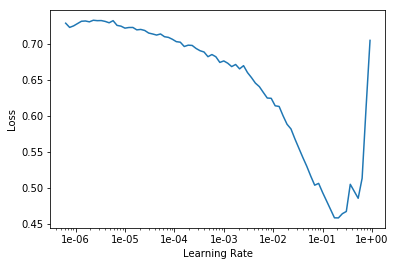

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.717651,0.711764,0.382353,00:00


In [ ]:
learn.save(base_dir + 'first')

In [ ]:
learn.load(base_dir + 'first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.584334,0.590743,0.784314,00:00


In [ ]:
learn.save(base_dir + 'second')

In [ ]:
learn.load(base_dir + 'second');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(30, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.258735,0.513593,0.784314,00:00
1,0.290390,0.493026,0.784314,00:00
2,0.302384,0.479022,0.784314,00:00
3,0.284509,0.471146,0.784314,00:00
4,0.282217,0.456481,0.784314,00:00
5,0.262229,0.450101,0.784314,00:00
6,0.249938,0.445601,0.784314,00:00
7,0.229589,0.454182,0.784314,00:00
8,0.213622,0.483014,0.784314,00:00
9,0.193578,0.471910,0.794118,00:00


In [ ]:
learn.save(base_dir + 'third')

In [ ]:
learn.load(base_dir + 'third');

# Error Analysis and Interpreting the Results

In [ ]:
learn.predict("Idź, Janku! w kredensie nie ma nikogo...")

(Category narrator, tensor(0), tensor([0.9719, 0.0281]))

In [ ]:
interp = TextClassificationInterpretation.from_learner(learn)

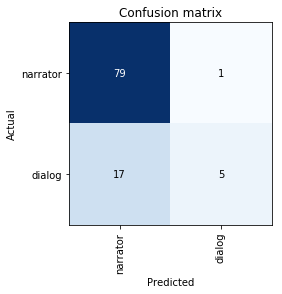

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁xxmaj ▁na ▁drugi ▁dzień ▁nie ▁wstał ▁xxmaj ▁janek , ▁a ▁trzeci ego ▁wieczorem ▁ko na ł ▁już ▁sobie ▁spokojnie ▁na ▁ta p cza nie ▁pod ▁z grze b nym ▁ ki li m kiem .",narrator,narrator,5.86,1.00
"▁xxbos ▁xxmaj ▁gdy ▁tylko ▁mógł ▁słyszeć ▁skrzypki , ▁czy ▁to ▁na ▁do ż y nkach , ▁czy ▁na ▁wesel u ▁jakim , ▁to ▁już ▁dla ▁niego ▁było ▁wielkie ▁święt o .",narrator,narrator,5.51,1.00
"▁xxbos ▁xxmaj ▁zapał ka ▁zaczęł a ▁migota ć ▁po ▁ścianie , ▁zrobił o ▁się ▁widno , ▁a ▁potem ...",narrator,narrator,5.44,1.00
"▁xxbos ▁xxmaj ▁przyszła ▁matka , ▁zabrał a ▁chłopak a , ▁ale ▁musiała ▁go ▁za nieść ▁do ▁domu ...",narrator,narrator,4.69,0.99
▁xxbos ▁xxmaj ▁biała ▁koszul a ▁migotał a ▁co raz ▁bliżej ▁drzwi ▁k r e d en s owych .,narrator,narrator,4.05,0.98
"▁xxbos ▁xxmaj ▁jakże ▁tu ▁sądzić ▁taką ▁bied ę , ▁co ▁ma ▁lat ▁dziesię ć ▁i ▁ledwo ▁na ▁nogach ▁stoi ?",narrator,dialog,3.63,0.03
▁xxbos ▁xxmaj ▁ale ▁ta ▁chęć ▁nie ▁w yszła ▁mu ▁na ▁dobre .,narrator,narrator,3.62,0.97
"▁xxbos ▁xxmaj ▁na ▁próżno , ▁le l ku , ▁prze la tuje sz ▁jeszcze ▁raz ▁i ▁woła sz : ▁"" nie ! ▁nie !"" ▁xxmaj ▁janek ▁już ▁w ▁kredensie .",narrator,narrator,3.39,0.97
▁xxbos ▁i ▁co ▁to ▁za ▁lud ▁arty st ów .,narrator,dialog,3.21,0.04
"▁xxbos ▁xxmaj ▁dopiero ▁jak ▁go ▁xxmaj ▁stach ▁w ▁sto d o le ▁wziął ▁garś cią , ▁rozciągną ł ▁na ▁ziemi ▁i ▁pod g iąwszy ▁koszul i nę ▁machną ł ▁od ▁u ch a , ▁dopiero ż ▁xxmaj ▁janek ▁ krzyknął :",narrator,narrator,2.97,0.95


In [ ]:
import matplotlib.cm as cm

test_text = 'Idź, Janku! w kredensie nie ma nikogo...'
interp.show_intrinsic_attention(test_text,cmap=cm.Purples)